Copyright (C) 2017 Glencoe Software, Inc. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

# Image Processing

* Connect to OMERO server
* List ROIs attached to the image
* Read pixels confined by `Analyze it!` ROI
* Find objects in the image
* Describe objects
* Create and upload OMERO ROIs
* Create and upload key-value pairs describing each ROI

### Connect to the OMERO server

In [54]:
%matplotlib notebook

'matplotlib (1.3.1)'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

from IPython.display import display, HTML

In [2]:
import omero
from omero.gateway import BlitzGateway

import pprint

In [106]:
from getpass import getpass
conn = BlitzGateway(
    raw_input("Username: "), getpass("OMERO Password: "),
    host=raw_input("Host: "), port=int(raw_input("Port: ")))
conn.connect()

Username: a
OMERO Password: ········
Host: your.host
Port: 4064


False

### User info

In [ ]:
user = conn.getUser()
print "Current user:"
print "   ID:", user.getId()
print "   Username:", user.getName()
print "   Full Name:", user.getFullName()
print "Member of:"
for g in conn.getGroupsMemberOf():
    print "   ID:", g.getName(), " Name:", g.getId()
group = conn.getGroupFromContext()
print "Current group: ", group.getName()

### Get list of ROIs and filter by name

In [12]:
image_id = raw_input("Image Id: ")
roi_service = conn.getRoiService()
rois = roi_service.findByImage(int(image_id), None).rois

roi_name = raw_input("ROI name: ")
print "Found ", len(rois), " ROIs"
result = None
for roi in rois:
    if roi.getName() is None:
        continue
    if roi.getName().getValue().lower() == roi_name.lower():
        result = roi
        print "Found a name match for ROI id: ", roi.id.val
        break

Image Id: 159010
ROI name: Analyse it!
Found  1  ROIs
Found a name match for ROI id:  418425


Reading tile: (195, 497, 523, 453)


<IPython.core.display.Javascript object>


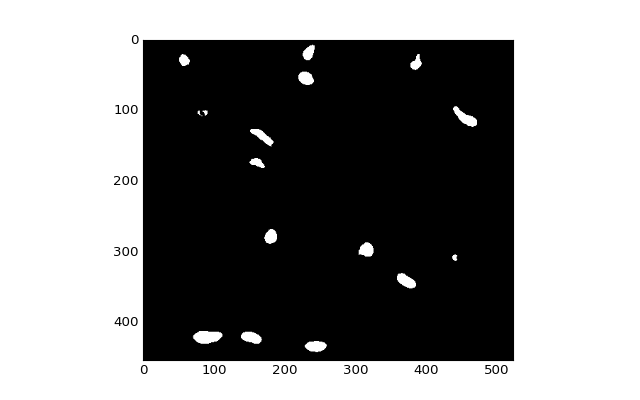

In [55]:
image = conn.getObject("Image", image_id)
primary_pixels = image.getPrimaryPixels()


rect = result.getShape(0)
x = rect.getX().getValue()
y = rect.getY().getValue()
width = rect.getWidth().getValue()
height = rect.getHeight().getValue()
tile = (int(x), int(y), int(width), int(height))
print "Reading tile:", tile
pixels = primary_pixels.getTile(0, 0, 0, tile)

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
imgplot = plt.imshow(pixels, cmap=plt.get_cmap('gray'))

### Preprocess pixels

In [16]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [73]:
thresh = threshold_otsu(pixels)
bw = closing(pixels > thresh, square(5))
cleared = clear_border(bw)

imgplot2 = plt.imshow(bw, cmap=plt.get_cmap('gray'))

In [77]:
# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=pixels)

regions = regionprops(label_image)
regions_filtered = []
for region in regions:
    if region.area >= 100:
        regions_filtered.append(region)
print "Found", len(regions_filtered), "objects"

Found 13 objects


### Show regions

<IPython.core.display.Javascript object>


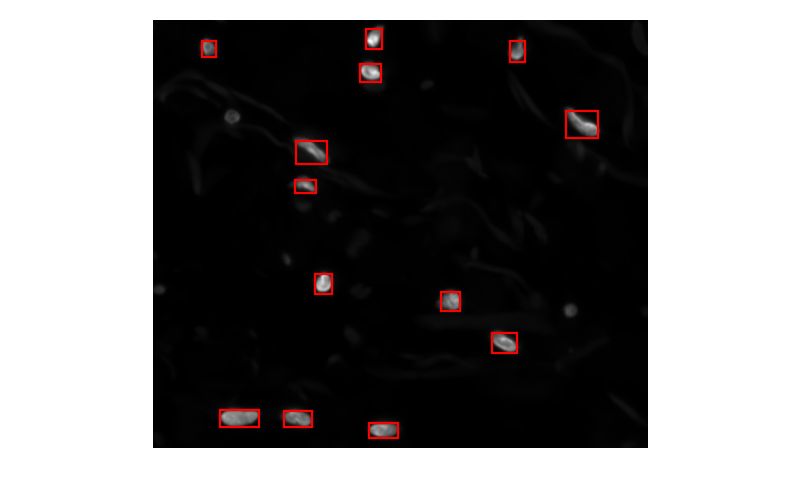

In [78]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(pixels, cmap=plt.get_cmap('gray'))

for region in regions_filtered:
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                               fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

### Convert regions to ROIs

In [79]:
image = omero.model.ImageI(image_id, False)

xShift = result.getShape(0).getX().getValue();
yShift = result.getShape(0).getY().getValue();

description = 'Created with Glencoe Software data analysis tools'
namespace = 'com.glencoesoftware.analysis'

rois = []
for region in regions_filtered:
    roi_el = omero.model.RoiI()
    x = region.centroid[1] + xShift
    y = region.centroid[0] + yShift
    point = omero.model.PointI()
    point.setCx(omero.rtypes.rdouble(x))
    point.setCy(omero.rtypes.rdouble(y))
    point.theZ = omero.rtypes.rint(0)
    point.theT = omero.rtypes.rint(0)
    roi_el.addShape(point)
    roi_el.setImage(image)
    rois.append(roi_el)
rois = conn.getUpdateService().saveAndReturnArray(rois)

print "Saved ", len(rois), " ROIs"

Saved  13  ROIs


### Add regions properties to ROIs

In [91]:
links = []
for k, roi in enumerate(rois):
    nv = []
    nv.append(omero.model.NamedValue("Area", str(regions_filtered[k].area)))
    nv.append(omero.model.NamedValue("Centroid", str(regions_filtered[k].centroid)))
    nv.append(omero.model.NamedValue("Convex Area", str(regions_filtered[k].convex_area)))
    nv.append(omero.model.NamedValue("Eccentricity", str(regions_filtered[k].eccentricity)))
    nv.append(omero.model.NamedValue("Extent", str(regions_filtered[k].extent)))
    nv.append(omero.model.NamedValue("Major Axis Length", str(regions_filtered[k].major_axis_length)))
    nv.append(omero.model.NamedValue("Minor Axis Length", str(regions_filtered[k].minor_axis_length)))
    nv.append(omero.model.NamedValue("Orientation", str(regions_filtered[k].orientation)))
    nv.append(omero.model.NamedValue("Perimeter", str(regions_filtered[k].perimeter)))
    nv.append(omero.model.NamedValue("Solidity", str(regions_filtered[k].solidity)))
    
    map_annotation = omero.model.MapAnnotationI()
    map_annotation.setMapValue(nv)
    map_annotation.setDescription(omero.rtypes.rstring(description))
    map_annotation.setNs(omero.rtypes.rstring(namespace))
    
    link = omero.model.RoiAnnotationLinkI()
    link.setParent(omero.model.RoiI(roi.id.val, False))
    link.setChild(map_annotation)
    links.append(link)
links = conn.getUpdateService().saveAndReturnArray(links)
print "Saved ", len(links), " key-value pairs"
    

Saved  13  key-value pairs


### Create OMERO.table

In [105]:
table = []
columns = []
columns.append(omero.grid.LongColumn('Index', '', []))
columns.append(omero.grid.ImageColumn('Image', '', []))
columns.append(omero.grid.RoiColumn('Roi', '', []))
columns.append(omero.grid.DoubleColumn('CenterX', '', []))
columns.append(omero.grid.DoubleColumn('CenterY', '', []))
columns.append(omero.grid.DoubleColumn('Area', '', []))
columns.append(omero.grid.DoubleColumn('Convex Area', '', []))
columns.append(omero.grid.DoubleColumn('Eccentricity', '', []))
columns.append(omero.grid.DoubleColumn('Extent', '', []))
columns.append(omero.grid.DoubleColumn('Major Axis Length', '', []))
columns.append(omero.grid.DoubleColumn('Minor Axis Length', '', []))
columns.append(omero.grid.DoubleColumn('Orientation', '', []))
columns.append(omero.grid.DoubleColumn('Perimeter', '', []))
columns.append(omero.grid.DoubleColumn('Solidity', '', []))

tableName = 'com.glencoesoftware.analysis.table'
table = conn.c.sf.sharedResources().newTable(1, tableName)
table.initialize(columns)

data = []
cx = [region.centroid[0] - xShift for region in regions_filtered]
cy = [region.centroid[1] - yShift for region in regions_filtered]
data.append(omero.grid.LongColumn('Index', '', range(len(rois))))
data.append(omero.grid.ImageColumn('Image', '', [int(image_id)] * len(rois)))
data.append(omero.grid.RoiColumn('Roi', '', [roi.id.val for roi in rois]))
data.append(omero.grid.DoubleColumn('CenterX', '', cx))
data.append(omero.grid.DoubleColumn('CenterY', '', cy))
data.append(omero.grid.DoubleColumn('Area', '', [region.area for region in regions_filtered]))
data.append(omero.grid.DoubleColumn('Convex Area', '', [region.convex_area for region in regions_filtered]))
data.append(omero.grid.DoubleColumn('Eccentricity', '', [region.eccentricity for region in regions_filtered]))
data.append(omero.grid.DoubleColumn('Extent', '', [region.extent for region in regions_filtered]))
data.append(omero.grid.DoubleColumn('Major Axis Length', '', [region.major_axis_length for region in regions_filtered]))
data.append(omero.grid.DoubleColumn('Minor Axis Length', '', [region.minor_axis_length for region in regions_filtered]))
data.append(omero.grid.DoubleColumn('Orientation', '', [region.orientation for region in regions_filtered]))
data.append(omero.grid.DoubleColumn('Perimeter', '', [region.perimeter for region in regions_filtered]))
data.append(omero.grid.DoubleColumn('Solidity', '', [region.solidity for region in regions_filtered]))

table.addData(data)
table.close()

orig_file = table.getOriginalFile()
orig_file_id = orig_file.id.val

file_ann = omero.model.FileAnnotationI()
file_ann.setFile(omero.model.OriginalFileI(orig_file_id, False))
file_ann = conn.getUpdateService().saveAndReturnObject(file_ann)

link = omero.model.ImageAnnotationLinkI()
link.setParent(omero.model.ImageI(image_id, False))
link.setChild(omero.model.FileAnnotationI(file_ann.getId().getValue(), False))
link = conn.getUpdateService().saveAndReturnObject(link)
print "Table saved ", orig_file.id.val

Table saved  158647
